# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Idea" data-toc-modified-id="Idea-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Idea</a></div><div class="lev2 toc-item"><a href="#Inverse-Model" data-toc-modified-id="Inverse-Model-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Inverse Model</a></div><div class="lev1 toc-item"><a href="#The-game" data-toc-modified-id="The-game-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The game</a></div><div class="lev2 toc-item"><a href="#The-environment" data-toc-modified-id="The-environment-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>The environment</a></div>

# Idea

## Inverse Model

Bayesian rat. 
- Parameters
    - Learning Rate
    - Weber Fixed
    - Discounting
    

# The game

## The environment

In [1]:
from itertools import count
import scipy.stats as st
import numpy as np

In [419]:
class DRRD():
    """
    
    """
    def __init__(self, criterion):
        # Time in seconds
        self.criterion = criterion
        self.action_history_ = []
        self.reward_history_ = []
        self.criterion_history = []
        
    def _reward(self, time):
        if time > self.criterion:
            return True
        else:
            return False
        
    def _store(self, action, reward, criterion):
        self.action_history_.append(action)
        self.reward_history_.append(reward)
        self.criterion_history.append(criterion)
        
    def play(self, Rat, max_rounds=1000):
        for r in range(max_rounds):
            action = Rat.act()
            reward = self._reward(action)
            self._store(action, reward, self.criterion)
            Rat.get_reward(reward)
            if Rat.tired_: break
                

class BayesianRat():
    """
    
    """
    def __init__(self, learning_rate=.01, discounting=1, weber=.15, 
                    likelihood_dist='normal', range=(0,6), dt=1e-3, 
                    prior='lognormal' , responses=None, rule='like'):
        
        self.weber = weber
        self.discounting = discounting
        self.learning_rate = learning_rate
        self.update_rule = rule
        self.dt = dt
        
        self.sup = np.arange(range[0], range[1], dt)
        
        
        self.prior_ = self._make_prior(prior)
        self.cdf_ = self.prior_.cumsum()
        self.prior_history = [self.prior_]
        self.likely_history = []
        
        
        self.likelihood_dist_ = self._make_lh(prior)
        
        self.model_logL_ = 0
        self.last_response_ = None
        self.responses = responses
        
        self.tired_ = False
        
    
    def _make_prior(self, prior):
        if prior == 'lognormal':
            return st.lognorm(scale=1, s=1).pdf(sup)*self.dt
        elif isinstance(prior, np.array):
            assert len(prior) == len(sup)
            assert prior.sum()== 1/dt
            return prior
    
    def _make_lh(self, likelihood_dist):
        if likelihood_dist == 'lognormal':
            return lambda t: st.lognorm(scale=t, s=self.weber).pdf(sup)
        elif likelihood_dist == 'normal':
            return lambda t: st.norm(loc=t, scale=self.weber*t).pdf(sup)
        
    def act(self):
        if self.responses is not None:
            self.last_response_ = self.responses.pop(0)
            if len(self.responses) == 0:
                self.tired = True
        else:
            self.last_response_ = self._sample_action()
        
        self.model_logL_ += np.log(self._model_likelihood(self.last_response_))
        return self.last_response_
    
    def _sample_action(self):
        return self.sup[np.abs(self.cdf_ - np.random.rand()).argmin()]
        
    def get_reward(self, reward):
        if reward:
            self._update_prior()
    
    def _update_prior(self):
        likely_time = self._time_likelihood(self.last_response_)
        self.likely_history.append(likely_time)
        
        if self.update_rule == 'like':
            update = likely_time
        elif self.update_rule == 'post':
            update = self.prior_ * likely_time
        
        
        self.prior_ = self.prior_*(1-self.learning_rate) + update*self.learning_rate
        self.prior_ /= self.prior_.sum()
        self.cdf_ = self.prior_.cumsum()
        self.prior_history .append(self.prior_)
        
    def _time_likelihood(self, time):
        lkl = self.likelihood_dist_(time)
        return lkl/lkl.sum()
    
    def _model_likelihood(self, response):
        return self.prior_[np.abs(self.sup - response).argmin()]
        
class GallistelRat():
    """
    
    """
    pass

        

In [433]:
bayes = BayesianRat()

In [434]:
task = DRRD(1.5)

In [435]:
task.play(bayes, 1000)

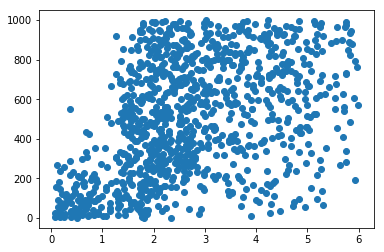

In [436]:
plt.scatter(task.action_history_,np.arange(1000))

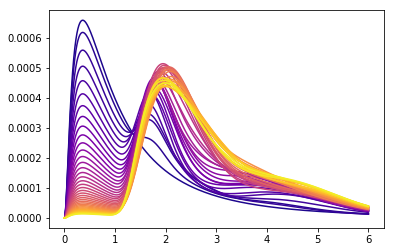

In [437]:
N=40
c = sns.color_palette('plasma', N)

for i in range(N):
    plt.plot(sup, bayes.prior_history[10*i], color=c[i])

---

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [98]:
prior = st.lognorm(scale=4, s=.15).pdf(sup)

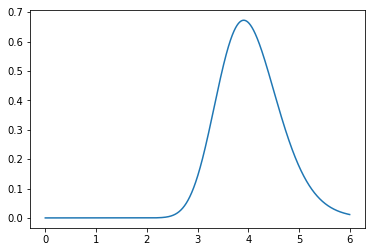

In [99]:
plt.plot(sup, prior)

In [26]:
cdf = prior.cumsum().reshape(-1,1)
cdf/=cdf.max()

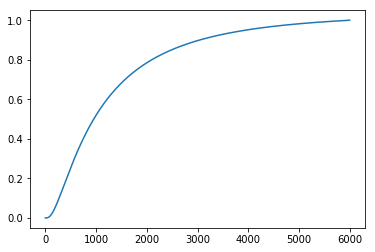

In [27]:
plt.plot(cdf)

In [44]:
N = 1000
s = sup[np.abs(cdf-np.random.random(size=(1,N))).argmin(axis=0)]

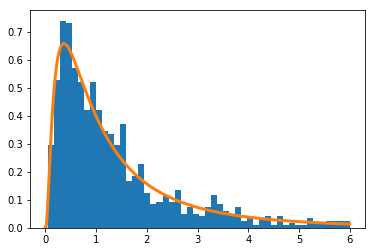

In [45]:
plt.hist(s,50, density=True);
plt.plot(sup, prior, linewidth=3)

In [47]:
s.mean()

1.3459909999999999

- Taxa média
- Bracketing